In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
USERS_INFO_CSV = os.path.join(ROOT_DIR, 'output', 'users', 'objs', '2022-02-04', 'user-objs.csv')
BASELINE_LOCATIONS_TXT = os.path.join(ROOT_DIR, 'input', 'locations.txt')

baseline_locations_df = pd.read_csv(BASELINE_LOCATIONS_TXT, sep='\n')
baseline_locations_df['locations'] = baseline_locations_df['locations'].map(str.strip)

df = pd.read_csv(USERS_INFO_CSV, dtype={
    'user_id': pd.Int64Dtype(),
    'screen_name': pd.StringDtype(),
    'location': pd.StringDtype(),
    'created_at': pd.StringDtype(),
    'name': pd.StringDtype(),
    'description': pd.StringDtype(),
    'statuses_count': pd.Int64Dtype(),
    'friends_count': pd.Int64Dtype(),
    'followers_count': pd.Int64Dtype(),
    'verified': bool,
    'protected': bool,
})


df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y') # 30s
df['location'] = df['location'].transform(lambda x: str(x).strip())
df['is_croatian'] = df['location'].transform(lambda x: x in baseline_locations_df['locations'].unique() 
                                                or 'croatia' in x.lower()
                                                or 'hrvatska' in x.lower())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314451 entries, 0 to 314450
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   user_id          314451 non-null  Int64              
 1   location         314451 non-null  object             
 2   screen_name      314451 non-null  string             
 3   name             313864 non-null  string             
 4   statuses_count   314451 non-null  Int64              
 5   friends_count    314451 non-null  Int64              
 6   followers_count  314451 non-null  Int64              
 7   description      237015 non-null  string             
 8   created_at       314451 non-null  datetime64[ns, UTC]
 9   verified         314451 non-null  bool               
 10  protected        314451 non-null  bool               
 11  is_croatian      314451 non-null  bool               
dtypes: Int64(4), bool(3), datetime64[ns, UTC](1), object(1), s

In [4]:
import string
accepted_chars = string.ascii_lowercase + 'čšćžđ'

def clean_location(location):
    location_names = ('hrvatska', 'croatia', 'croacia', 'croatie', 'republic of croatia', 'republika hrvatska')
    transformed_location = location.replace('  ', ' ').strip().lower()
    for name in location_names:
        if transformed_location == name:
            return 'Hrvatska'
        
        if name in location.lower():
            transformed_location = transformed_location.replace('hrvatska', '')
            transformed_location = transformed_location.replace('croatia', '')
            transformed_location = transformed_location.replace('republic of', '')
        
        for char in location.lower():
            if char not in accepted_chars and char != ' ':
                transformed_location = transformed_location.replace(char, '')
    if transformed_location.strip() == '':
        transformed_location = 'Hrvatska'
    return transformed_location.strip().title()

df['clean_location'] = df['location'].transform(clean_location)

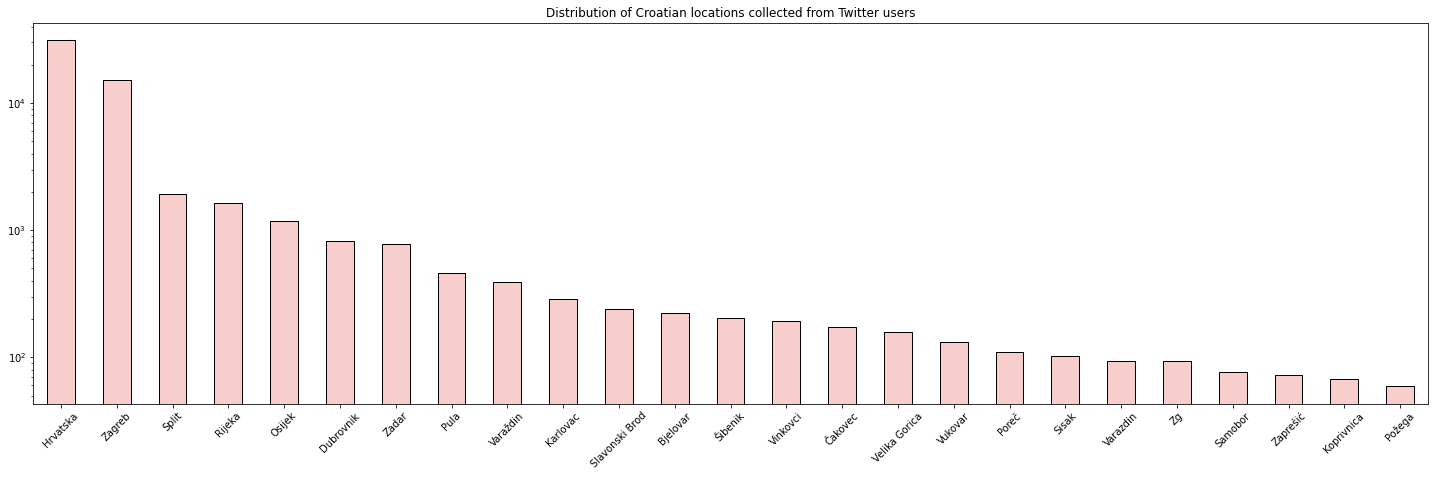

In [34]:
croatian_df = df[(df['is_croatian'] == True) & (df['clean_location'] != 'Europe')]

croatian_df.groupby('clean_location').size() \
    .sort_values(ascending=False).head(25) \
    .plot.bar(
        title='Distribution of Croatian locations collected from Twitter users', 
        figsize=(25, 7), 
        rot=45, 
        logy=True, 
        color='#f8cecc',
        edgecolor='black'
    )

plt.xlabel(None)
plt.show()

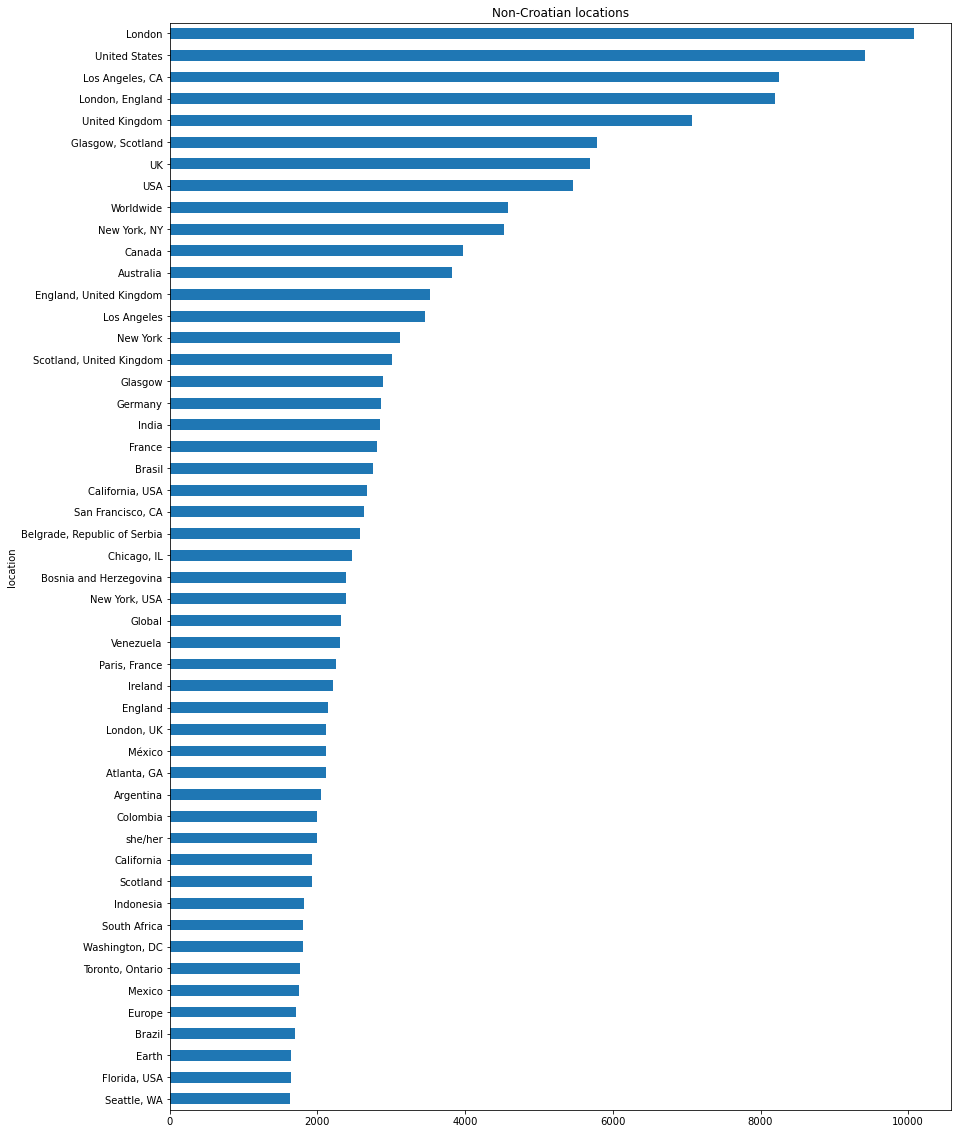

In [ ]:
df[
    (df['is_croatian'] == False)
    & (df['location'] != '<NA>')
].groupby('location').size() \
 .sort_values(ascending=False).head(50) \
 .iloc[::-1].plot.barh(title='Non-Croatian locations',figsize=(14, 20))
plt.show()

In [ ]:
len(df[df['is_croatian'] == True])

65526

In [6]:
df = df.drop_duplicates('user_id')
df[
    (df['is_croatian'] == True)
    & (df['protected'] == False)
    & (df['statuses_count'] > 10)
    & (df['friends_count'] > 10)
    & (df['friends_count'] < 5000)
    & (df['followers_count'] > 10)
    & (df['followers_count'] < 5000)
].sort_values(by='friends_count', ascending=False) #.to_csv('new_baseline_user_ids.csv', encoding='utf-8', index=False)

,user_id,location,screen_name,name,statuses_count,friends_count,followers_count,description,created_at,verified,protected,is_croatian,clean_location
1286861,3358478140,Republic of Croatia,klitorino,Zubi Vana Zu,1415,4999,1029,#faith #prophetic #ww3 #teleportation #intima...,2015-07-04 10:27:47+00:00,False,False,True,Hrvatska
280876,680383,Croatia,BorraBomber,CEO Borra 🎩,38894,4998,1160,Kadrovik. Rokabili. 43. 🇪🇺🇭🇷,2007-01-22 12:43:01+00:00,False,False,True,Hrvatska
1513859,767070895403851776,Republic of Croatia,djordje_e,Đorđe,112,4997,567,<NA>,2016-08-20 18:48:47+00:00,False,False,True,Hrvatska
1162784,2926174355,"Zagreb, Croatia",suzich_q,Suzana 🌠,23939,4996,3699,law ⚖ / art 👩‍🎨 / music 🎵 https://t.co/CafIpW...,2014-12-17 02:01:28+00:00,False,False,True,Zagreb
728647,215630332,Split - Croatia,Bozomegamix,Illyric Dalmatino,3723,4996,1221,"Worshiper, Charismatic, Prophetic, Open Source...",2010-11-14 13:46:30+00:00,False,False,True,Split
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346314,279996981,Zagreb,arwenlarpshop,Arwen LARP shop,11,11,32,First LARP store in Croatia,2011-04-10 12:29:48+00:00,False,False,True,Zagreb
374534,588103796,"Pula, Croatia",MladenJergovic,Mladen Jergović,1797,11,164,<NA>,2012-05-23 07:58:27+00:00,False,False,True,Pula
1332300,2154818960,"Zagreb, Croatia",MusicShopNo1,Music Shop No1,1073,11,26,Generalni uvoznik za niz poznatih brendova u s...,2013-10-25 12:31:57+00:00,False,False,True,Zagreb
121236,352618464,"Samobor, Republic of Croatia",kbruci,Karlo Bruci,14,11,38,"AV & acoustics enthusiast, Crestron programmer...",2011-08-10 21:36:50+00:00,False,False,True,Samobor


In [6]:
# output_baseline_ids

output_df = df[
    (df['is_croatian'] == True)
    & (df['protected'] == False)
    & (df['statuses_count'] > 10)
    & (df['friends_count'] > 10)
    & (df['friends_count'] < 5000)
    & (df['followers_count'] > 10)
    & (df['followers_count'] < 5000)
    | (df['screen_name'].isin(('ViliBeros', 'nbakic')))
].sort_values(by='followers_count')

#output_df.user_id.to_json('../../output/new_baseline-user-ids.json', orient='records')
output_df.head()
output_df[output_df['screen_name'] == 'novilisthr']

,user_id,location,screen_name,name,statuses_count,friends_count,followers_count,description,created_at,verified,protected,is_croatian


In [ ]:
import pandas as pd
import os

_df = pd.read_csv('../../scrape_tweets/input/profiles_get_tweets.csv')
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50116 entries, 0 to 50115
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            50116 non-null  int64  
 1   Unnamed: 0.1          50116 non-null  int64  
 2   Unnamed: 0.1.1        50116 non-null  int64  
 3   profile_id            50116 non-null  float64
 4   Location              50116 non-null  object 
 5   Followers             50116 non-null  float64
 6   Friends               50116 non-null  float64
 7   Statuses              50116 non-null  float64
 8   last_time_check       50116 non-null  object 
 9   tweets_collectted_at  50116 non-null  object 
 10  Failed                50116 non-null  bool   
 11  Username              50116 non-null  object 
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 4.3+ MB


<AxesSubplot:title={'center':'Croatian locations'}, ylabel='Location'>

C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127469 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0, flags=flags)


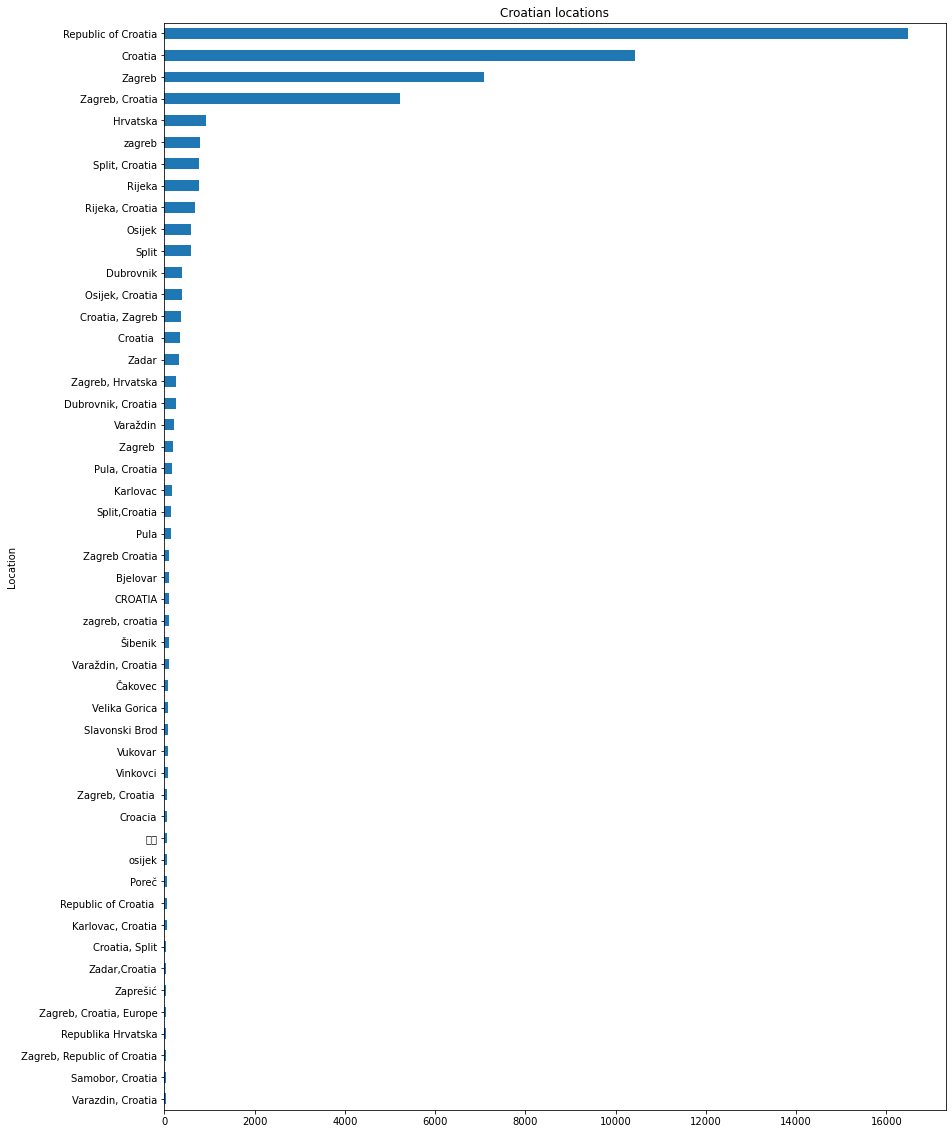

In [ ]:
_df.groupby('Location').size() \
 .sort_values(ascending=False).head(50) \
 .iloc[::-1].plot.barh(title='Croatian locations',figsize=(14, 20))